In [1]:
# === Marketoria synthetic uplift dataset ===
import numpy as np, pandas as pd
rng = np.random.default_rng(22)
n = 100_000

# features
age = rng.integers(18, 75, n)
income = np.exp(rng.normal(10.8, 0.6, n))  # log-normal
web_visits = rng.integers(0, 30, n)
prior_purch = rng.binomial(1, 0.25, n)
segment = rng.choice(list("ABCDE"), n, p=[.15,.25,.18,.22,.20])

# assign treatment (randomized but slightly imbalanced by segment to test robustness)
p_treat = np.where(segment=='B', 0.55, 0.50)
T = rng.binomial(1, p_treat)

# baseline conversion logit
logit_base = (
    -3.0 + 0.03*(age-40) + 0.00001*(income-60_000) + 0.05*web_visits
    + 0.8*prior_purch + np.where(segment=='E', 0.2, 0) - np.where(segment=='A', 0.2, 0)
)

# heterogeneous treatment effect (uplift) depends on features
tau = (
    0.6*(web_visits>10) + 0.4*prior_purch + 0.000006*(income-60_000)
    - 0.02*(age-40) + np.where(segment=='B', 0.2, 0) - np.where(segment=='C', 0.1, 0)
)
# cap uplift to keep probabilities valid
tau = np.clip(tau, -1.5, 1.5)

# final purchase probability
logit = logit_base + T * tau
p = 1/(1+np.exp(-logit))
y = rng.binomial(1, np.clip(p, 0, 0.999))

df = pd.DataFrame({
    "age":age,"income":income,"web_visits":web_visits,"prior_purch":prior_purch,
    "segment":segment,"treatment":T,"purchase":y
})
df.to_csv("marketoria_uplift.csv", index=False)
df.head(), df["treatment"].mean(), df["purchase"].mean()


(   age        income  web_visits  prior_purch segment  treatment  purchase
 0   61  22266.325397          20            1       A          0         0
 1   38  51643.157633          26            0       A          0         0
 2   55  16378.150288           1            0       B          1         0
 3   29  32014.151079          20            0       E          1         0
 4   71  68614.269567          20            0       D          0         0,
 np.float64(0.51386),
 np.float64(0.19176))

In [2]:
import pandas as pd, scipy.stats as st
df = pd.read_csv("marketoria_uplift.csv")

# 1) Balance checks (treatment vs control distributions)
for col in ["age","income","web_visits"]:
    t = df.loc[df.treatment==1, col]; c = df.loc[df.treatment==0, col]
    print(col, "KS p=", st.ks_2samp(t, c, alternative="two-sided").pvalue)

for col in ["prior_purch","segment"]:
    ct = pd.crosstab(df[col], df["treatment"], normalize="columns")
    chi2, p, *_ = st.chi2_contingency(pd.crosstab(df[col], df["treatment"]))
    print(col, "Chi2 p=", p)

# 2) Raw uplift sanity: difference in means
uplift_dm = df.loc[df.treatment==1, "purchase"].mean() - df.loc[df.treatment==0, "purchase"].mean()
uplift_dm


age KS p= 0.9945691084550815
income KS p= 0.8161279034909104
web_visits KS p= 0.5409210151069745
prior_purch Chi2 p= 0.6481883067259084
segment Chi2 p= 1.3034091905550813e-41


np.float64(0.06686020087137323)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import numpy as np

X = df.drop(columns=["purchase"])
y = df["purchase"].values
cat = ["segment"]
num = ["age","income","web_visits","prior_purch","treatment"]

pre = ColumnTransformer([
    ("num","passthrough", num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat)
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, stratify=df["treatment"], random_state=42)

# Split train by treatment
tr = X_tr["treatment"].values==1
cr = X_tr["treatment"].values==0

# two models
clf_t = Pipeline([("pre", pre), ("gb", GradientBoostingClassifier(random_state=42))]).fit(X_tr[tr], y_tr[tr])
clf_c = Pipeline([("pre", pre), ("gb", GradientBoostingClassifier(random_state=42))]).fit(X_tr[cr], y_tr[cr])

# predicted uplift = P(y=1|T=1,x) - P(y=1|T=0,x)
p_t = clf_t.predict_proba(X_te)[:,1]
p_c = clf_c.predict_proba(X_te)[:,1]
uplift_tm = p_t - p_c
uplift_tm[:5]


array([ 0.00690799,  0.01682039,  0.05285231, -0.07365567,  0.20381214])

In [4]:
from sklearn.ensemble import RandomForestClassifier
clf_t2 = Pipeline([("pre", pre), ("rf", RandomForestClassifier(n_estimators=400, random_state=42,n_jobs=-1))]).fit(X_tr[tr], y_tr[tr])
clf_c2 = Pipeline([("pre", pre), ("rf", RandomForestClassifier(n_estimators=400, random_state=42,n_jobs=-1))]).fit(X_tr[cr], y_tr[cr])

uplift_tl = clf_t2.predict_proba(X_te)[:,1] - clf_c2.predict_proba(X_te)[:,1]
uplift_tl[:5]


array([-0.04  , -0.29  , -0.0425, -0.005 , -0.1   ])

In [5]:
import numpy as np, pandas as pd
def qini_auc(uplift, y, t, frac_bins=20):
    # rank by predicted uplift desc
    order = np.argsort(-uplift)
    y, t = y[order], t[order]
    n = len(y); step = n//frac_bins
    gains = [0]; treated_cum=0; control_cum=0; uplift_cum=0
    for i in range(step, n+step, step):
        idx = slice(0, min(i,n))
        yt, yc = y[idx][t[idx]==1], y[idx][t[idx]==0]
        gains.append( (yt.mean() if yt.size else 0) - (yc.mean() if yc.size else 0) )
    gains = np.cumsum(gains)
    auuc = np.trapz(gains, dx=1/frac_bins)
    return gains, auuc

y_te_arr = y_te
t_te_arr = X_te["treatment"].values

g_tm, auuc_tm = qini_auc(uplift_tm, y_te_arr, t_te_arr)
g_tl, auuc_tl = qini_auc(uplift_tl, y_te_arr, t_te_arr)
auuc_tm, auuc_tl


/tmp/ipython-input-2182844327.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auuc = np.trapz(gains, dx=1/frac_bins)


(np.float64(1.8095321885426345), np.float64(1.2921724000875983))

In [6]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

# Reuse your fitted pipelines: clf_t, clf_c, and the test features list
joblib.dump({"t": clf_t, "c": clf_c}, "uplift_two_model.joblib")

# optional: a tiny helper to compute uplift on a DataFrame
def predict_uplift(df_input):
    models = joblib.load("uplift_two_model.joblib")
    p_t = models["t"].predict_proba(df_input)[:,1]
    p_c = models["c"].predict_proba(df_input)[:,1]
    return p_t - p_c
# quick smoke test
X_te.head(1), float(predict_uplift(X_te.head(1)))


/tmp/ipython-input-2694235269.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_te.head(1), float(predict_uplift(X_te.head(1)))


(       age        income  web_visits  prior_purch segment  treatment
 59056   23  29117.232086           1            0       B          0,
 0.006907987049430197)

In [7]:
# In your Colab notebook
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("marketoria_uplift.csv")
X = df.drop(columns=["purchase"])
_, H = train_test_split(X, test_size=0.3, stratify=df["treatment"], random_state=42)
H.to_csv("marketoria_holdout.csv", index=False)


In [9]:
# Cell: Qini helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def qini_curve(uplift, y, t, frac_bins: int = 20):
    """
    Build Qini / uplift gains curve.
    uplift: predicted uplift scores (len n)
    y:      binary outcome (0/1)
    t:      treatment indicator (0/1)
    Returns: DataFrame with columns:
      'frac_targeted', 'gain', 'cum_gain'
    And the AUUC (area under uplift curve).
    """
    uplift = np.asarray(uplift).reshape(-1)
    y = np.asarray(y).astype(int).reshape(-1)
    t = np.asarray(t).astype(int).reshape(-1)

    # rank by predicted uplift (desc)
    order = np.argsort(-uplift)
    y = y[order]
    t = t[order]

    n = len(y)
    step = max(1, n // frac_bins)

    # cumulative treated/control positives
    cum_gain = []
    for end in range(step, n + 1, step):
        idx = slice(0, end)
        # mean outcome in treated among top-k
        yt = y[idx][t[idx] == 1]
        yc = y[idx][t[idx] == 0]
        mt = yt.mean() if yt.size else 0.0
        mc = yc.mean() if yc.size else 0.0
        # Qini: difference in mean outcomes at each slice
        cum_gain.append(mt - mc)

    gains = np.array(cum_gain)
    frac_targeted = np.arange(step, n + 1, step) / n

    # area under uplift curve
    auuc = np.trapezoid(gains, x=frac_targeted)

    df = pd.DataFrame({
        "frac_targeted": frac_targeted,
        "gain": gains,
        "cum_gain": gains  # just an alias; can rename if you prefer
    })
    return df, float(auuc)

def qini_plot(curves, title="Qini / Uplift Gains"):
    """
    curves: list of tuples (label, df_curve, auuc_float)
    """
    plt.figure(figsize=(7,5))
    for label, dfc, area in curves:
        plt.plot(dfc["frac_targeted"], dfc["cum_gain"], label=f"{label} (AUUC={area:.3f})")
    # random baseline around 0
    xs = np.linspace(0,1,50)
    plt.plot(xs, np.zeros_like(xs), "--", alpha=0.6, label="random baseline")
    plt.xlabel("Fraction targeted")
    plt.ylabel("Incremental gain (treated − control)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()


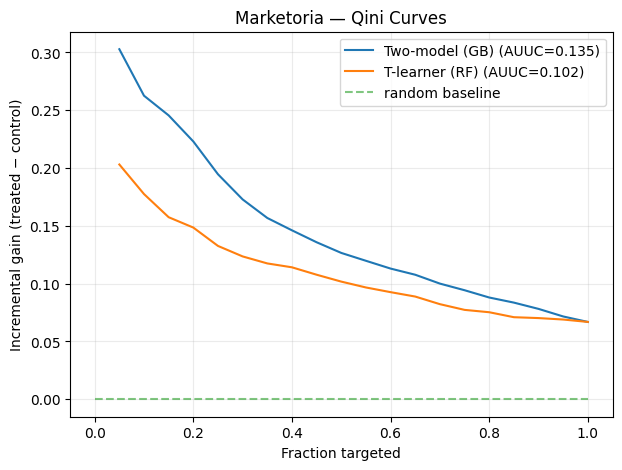

{'AUUC_two_model': 0.1352, 'AUUC_t_learner': 0.1019}


In [10]:
# Cell: Build & plot curves for two models
# Example variables (you likely already have them):
# uplift_tm  = uplift from two-model GradientBoosting
# uplift_tl  = uplift from T-learner RandomForest
# y_te_arr   = y_test values (0/1)
# t_te_arr   = treatment flags (0/1)

curve_tm, auuc_tm = qini_curve(uplift_tm, y_te_arr, t_te_arr, frac_bins=20)
curve_tl, auuc_tl = qini_curve(uplift_tl, y_te_arr, t_te_arr, frac_bins=20)

qini_plot([
    ("Two-model (GB)", curve_tm, auuc_tm),
    ("T-learner (RF)", curve_tl, auuc_tl),
], title="Marketoria — Qini Curves")

print({"AUUC_two_model": round(auuc_tm, 4), "AUUC_t_learner": round(auuc_tl, 4)})


In [11]:
# Cell 1: Qini helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def qini_curve(uplift, y, t, frac_bins: int = 20):
    """
    Build Qini / uplift gains curve.

    uplift: predicted uplift scores (len n)
    y:      binary outcome (0/1)
    t:      treatment indicator (0/1)
    Returns:
      df:   DataFrame with columns ['frac_targeted','gain','cum_gain']
      auuc: area under uplift curve (float)
    """
    uplift = np.asarray(uplift).reshape(-1)
    y = np.asarray(y).astype(int).reshape(-1)
    t = np.asarray(t).astype(int).reshape(-1)

    # rank by predicted uplift (desc)
    order = np.argsort(-uplift)
    y, t = y[order], t[order]

    n = len(y)
    step = max(1, n // frac_bins)

    # cumulative treated/control positives slice-by-slice
    cum_gain = []
    for end in range(step, n + 1, step):
        idx = slice(0, end)
        yt = y[idx][t[idx] == 1]
        yc = y[idx][t[idx] == 0]
        mt = yt.mean() if yt.size else 0.0
        mc = yc.mean() if yc.size else 0.0
        # Qini = treated mean - control mean at each slice
        cum_gain.append(mt - mc)

    gains = np.array(cum_gain)
    frac_targeted = np.arange(step, n + 1, step) / n

    # area under uplift curve (AUUC)
    # (np.trapezoid is new name; trapezoid works on recent NumPy)
    try:
        auuc = np.trapezoid(gains, x=frac_targeted)
    except Exception:
        auuc = np.trapz(gains, x=frac_targeted)

    df = pd.DataFrame({
        "frac_targeted": frac_targeted,
        "gain": gains,
        "cum_gain": gains   # alias; keep if you prefer 'cum_gain'
    })
    return df, float(auuc)

def qini_plot(curves, title="Marketoria — Qini Curves"):
    """
    curves: list of tuples (label: str, df_curve: pd.DataFrame, auuc: float)
    returns: matplotlib Figure
    """
    fig = plt.figure(figsize=(7, 5))
    for label, dfc, area in curves:
        plt.plot(dfc["frac_targeted"], dfc["cum_gain"],
                 label=f"{label} (AUUC={area:.3f})")
    # random baseline ~ 0
    xs = np.linspace(0, 1, 50)
    plt.plot(xs, np.zeros_like(xs), "--", alpha=0.6, label="random baseline")
    plt.xlabel("Fraction targeted")
    plt.ylabel("Incremental gain (treated – control)")
    plt.title(title)
    plt.grid(alpha=0.25)
    plt.legend()
    plt.tight_layout()
    return fig


{'AUUC_two_model': 0.1352, 'AUUC_t_learner': 0.1019}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

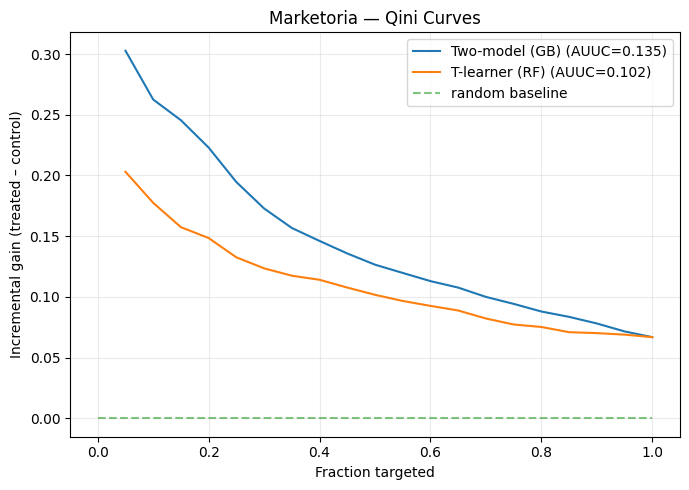

In [12]:
# Cell 2: Build + plot + save + download

# If needed, uncomment and wire up your existing variables:
# uplift_tm = ...  # two-model uplift scores on test set
# uplift_tl = ...  # T-learner uplift scores on test set
# y_te_arr  = ...  # 0/1 outcomes
# t_te_arr  = ...  # 0/1 treatment flags

# Build curves
curve_tm, auuc_tm = qini_curve(uplift_tm, y_te_arr, t_te_arr, frac_bins=20)
curve_tl, auuc_tl = qini_curve(uplift_tl, y_te_arr, t_te_arr, frac_bins=20)

# Plot
fig = qini_plot([
    ("Two-model (GB)", curve_tm, auuc_tm),
    ("T-learner (RF)", curve_tl, auuc_tl),
])

print({"AUUC_two_model": round(auuc_tm, 4), "AUUC_t_learner": round(auuc_tl, 4)})

# Save PNG + CSVs
png_path = "qini_curves.png"
fig.savefig(png_path, dpi=160)

curve_tm.assign(model="two_model").to_csv("qini_curve_two_model.csv", index=False)
curve_tl.assign(model="t_learner").to_csv("qini_curve_t_learner.csv", index=False)

# One combined CSV (optional)
pd.concat([
    curve_tm.assign(model="two_model"),
    curve_tl.assign(model="t_learner")
], ignore_index=True).to_csv("qini_curves_combined.csv", index=False)

# Offer downloads in Colab
try:
    from google.colab import files
    files.download(png_path)
    files.download("qini_curves_combined.csv")
except Exception as e:
    # Not on Colab: print paths so you can fetch them from the notebook files pane
    print("Saved files:", png_path, "qini_curves_combined.csv")
